In [27]:
# Importing required libraries
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import griddata
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import ast
import joblib
from xgboost import XGBClassifier
import pandas as pd
import joblib
from scipy.ndimage import gaussian_filter

print(pd.__version__)
print(joblib.__version__)

2.2.3
1.2.0


In [28]:
GRID_COLS = 50
GRID_ROWS = 120
ENDZONE_ROWS = 20

In [29]:

def fit_model(df, config, features=['thrower_x', 'thrower_y'], target_feature='outcome'):
    X = df[features].values
    y = df[target_feature]


    model_class = config['model']
    model_params = config.get('params', {})

    # Initialize and fit the model
    model = model_class(**model_params)
    model.fit(X, y)
    
    return model

config = {
    'logreg': {
        'model': LogisticRegression
    },
    'knn': {
        'model': KNeighborsClassifier,
        'params': {'n_neighbors': 100, 'weights': 'distance'}
    },
    'xgb': {
        'model': XGBClassifier,
        'params': {
            'n_estimators': 100,  # Number of trees
            'learning_rate': 0.1,  # Step size shrinkage
            'max_depth': 6,  # Maximum depth of a tree
            'subsample': 0.8,  # Subsample ratio of the training data
            'colsample_bytree': 0.8,  # Subsample ratio of columns for each tree
            'objective': 'binary:logistic',  # Use logistic regression for binary classification
            'eval_metric': 'logloss',  # Evaluation metric to optimize
            'random_state': 42  # For reproducibility
        }
    }
}

In [30]:
def apply_loess_smoothing(df, outcome_col='predicted_prob_logreg', frac=0.2):
    lowess = sm.nonparametric.lowess
    loess_x = lowess(df[outcome_col], df['thrower_x'], frac=frac)
    loess_y = lowess(df[outcome_col], df['thrower_y'], frac=frac)
    
    # Create DataFrames for LOESS results
    loess_x_df = pd.DataFrame(loess_x, columns=['thrower_x', 'smoothed_prob_x'])
    loess_y_df = pd.DataFrame(loess_y, columns=['thrower_y', 'smoothed_prob_y'])
    
    return loess_x_df, loess_y_df

def get_grid_from_loess(loess_x, loess_y, endzone=False):
    x_grid = np.linspace(loess_x['thrower_x'].min(), loess_x['thrower_x'].max(), GRID_COLS)
    if not endzone:
        y_grid = np.linspace(loess_y['thrower_y'].min(), loess_y['thrower_y'].max(), GRID_ROWS - ENDZONE_ROWS)
    else:
        y_grid = np.linspace(loess_y['thrower_y'].min(), loess_y['thrower_y'].max(), GRID_ROWS)
    xv, yv = np.meshgrid(x_grid, y_grid)

    grid_z_x = griddata(loess_x['thrower_x'], loess_x['smoothed_prob_x'], xv, method='linear')

    # Interpolate LOESS results for thrower_y
    grid_z_y = griddata(loess_y['thrower_y'], loess_y['smoothed_prob_y'], yv, method='linear')

    # Step 5: Combine the two smoothed results (average them)
    grid_z_combined = (grid_z_x + grid_z_y) / 2
    return grid_z_combined

In [31]:
def get_knn_df(df, k=1000):
    nrows = GRID_ROWS - ENDZONE_ROWS
    ncols = GRID_COLS
    X = df.loc[:, ['thrower_x_normalized', 'thrower_y_normalized']].values
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    x_coords = np.linspace(-26.66, 26.67, ncols)
    y_coords = np.linspace(0, 100, nrows)
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)
    arr = np.zeros((nrows, ncols))
    score_counts = np.zeros_like(arr)
    grid_x_n = (grid_x - df.thrower_x.min()) / (df.thrower_x.max() - df.thrower_x.min())
    grid_y_n = (grid_y - df.thrower_y.min()) / (df.thrower_y.max() - df.thrower_y.min())
    coords_n = np.vstack((grid_x_n.ravel(), grid_y_n.ravel())).T
    arr_df = pd.DataFrame(arr, index=range(1, nrows + 1), columns=range(1, ncols + 1))
    arr_df.columns = range(1, ncols + 1)
    arr_df['Y'] = range(1, nrows + 1)

    # Visualization preparation
    arr_melt = arr_df.melt(id_vars='Y')
    arr_melt.columns = ['thrower_y', 'thrower_x', 'spacial_knn_predictions']
    arr_melt['thrower_y'] = arr_melt['thrower_y'] * (100 / nrows)
    arr_melt['thrower_y'] = 100 - arr_melt['thrower_y']

    distances, indices = knn.kneighbors(coords_n)
    for i in range(k):
        score_counts += df.iloc[indices[:, i]]['outcome'].values.reshape(nrows, ncols)
    arr = score_counts / k
    arr_df = pd.DataFrame(arr, index=range(1, nrows + 1), columns=range(1, ncols + 1))
    arr_df.columns = range(1, ncols + 1)
    arr_df['Y'] = range(1, nrows + 1)

    # Visualization preparation
    arr_melt = arr_df.melt(id_vars='Y')
    arr_melt.columns = ['thrower_y', 'thrower_x', 'spacial_knn_predictions']
    arr_melt['thrower_y'] = arr_melt['thrower_y'] * (100 / nrows)
    return arr_melt


In [32]:
def plot_heatmap(ax, df, grid=None, outcome_col=None, endzone=False, contour_every=4, title=''):
    if outcome_col is None and grid is None:
        print('outcome col and grid cannot both be empty')
        return
    ax.set_title(title)
    ax.set_xlabel('Thrower X')
    ax.set_ylabel('Thrower Y')
    if grid is not None:
        sns.heatmap(grid, ax=ax, xticklabels=5, yticklabels=10, cmap='coolwarm', alpha=0.7, linewidths=0.5, linecolor='white')
    else:
        grid = df[['thrower_y', 'thrower_x', outcome_col]].astype(float).pivot(index='thrower_y', columns='thrower_x', values=outcome_col)
        sns.heatmap(grid, ax=ax, xticklabels=5, yticklabels=10, cmap='coolwarm', alpha=0.7, linewidths=0.5, linecolor='white')

    x_grid = np.linspace(df['thrower_x'].min(), df['thrower_x'].max(), GRID_COLS)
    if not endzone:
        nrows = GRID_ROWS - ENDZONE_ROWS
    else:
        nrows = GRID_ROWS
    
    contour_levels = [x / 100 for x in range(0, 100, contour_every)]
    y_grid = np.linspace(df['thrower_y'].min(), df['thrower_y'].max(), nrows)
    xv, yv = np.meshgrid(x_grid, y_grid)
    scaled_x_array = (xv - xv.min()) / (xv.max() - xv.min()) * (GRID_COLS - 0) + 0
    scaled_y_array = (yv - yv.min()) / (yv.max() - yv.min()) * (nrows - 0) + 0

    contour = ax.contour(scaled_x_array, scaled_y_array, grid, levels=contour_levels, colors='black', linewidths=1)

    ax.set_xticks(np.linspace(0, GRID_COLS, 11))
    ax.set_xticklabels(np.round(np.linspace(df['thrower_x'].min(), df['thrower_x'].max(), 11), 2))
    ax.set_yticks(np.linspace(0, nrows, 11))
    ax.set_yticklabels(np.round(np.linspace(df['thrower_y'].min(), df['thrower_y'].max(), 11).astype(int)))
    ax.axhline(y=20, color='black', linestyle='-', linewidth=1)
    ax.axhline(y=100, color='black', linestyle='-', linewidth=1)
    ax.clabel(contour, inline=True, fontsize=10, fmt='%.2f')
    return grid

def get_logreg_grid(df, model):
    x_min = df['thrower_x'].min()
    x_max = df['thrower_x'].max()

    y_min = df['thrower_y'].min()
    y_max = df['thrower_y'].max()

    # Create linear spaces
    x_space = np.linspace(x_min, x_max, GRID_COLS)
    y_space = np.linspace(y_min, y_max, GRID_ROWS - ENDZONE_ROWS)
    x_grid, y_grid = np.meshgrid(x_space, y_space)
    grid_df = pd.DataFrame({
        'thrower_x': x_grid.ravel(),
        'thrower_y': y_grid.ravel()
    })
    grid = model.predict_proba(grid_df)[:,1].reshape(GRID_ROWS - ENDZONE_ROWS, GRID_COLS)
    return grid

In [33]:
def create_completion_map(model, thrower_x, thrower_y, ax, scaler, smooth=False, contour_every=5, frac=0.2, show=False, title_addition=''):
    # Create a grid of receiver positions
    x_coords = np.linspace(-26.6, 26.67, GRID_COLS)
    y_coords = np.linspace(0, 120, GRID_ROWS)
    xv, yv = np.meshgrid(x_coords, y_coords)
    
    # Flatten the grid to pass into the model
    receiver_grid = np.column_stack((xv.flatten(), yv.flatten()))
    receiver_grid = scaler.transform(receiver_grid)

    # Create an array of thrower positions repeated for each receiver position
    thrower_grid = np.column_stack((np.full(receiver_grid.shape[0], thrower_x), 
                                    np.full(receiver_grid.shape[0], thrower_y)))
    thrower_grid = scaler.transform(thrower_grid)

    # Combine thrower and receiver positions for prediction
    X_test = np.column_stack((thrower_grid, receiver_grid))
    
    # Predict completion probabilities
    probabilities = model.predict_proba(X_test)[:, 1]  # Get the probability of completion (class 1)
    # Reshape probabilities to match the grid
    prob_grid = pd.DataFrame(probabilities.reshape(GRID_ROWS, GRID_COLS))
    
    if smooth:
        prob_grid.columns = range(1, GRID_COLS + 1)
        prob_grid['Y'] = range(1, GRID_ROWS + 1)
        arr_melt = prob_grid.melt(id_vars='Y')
        arr_melt.columns = ['thrower_y', 'thrower_x', 'completion_prob']
        loess_x, loess_y = apply_loess_smoothing(arr_melt, 'completion_prob')
        prob_grid = get_grid_from_loess(loess_x, loess_y, endzone=True)
    if show == False:
        return prob_grid
    # Plot the completion map using the passed axis
    sns.heatmap(prob_grid, xticklabels=5, yticklabels=10, cmap='coolwarm', alpha=0.7, linewidths=0.5, linecolor='white', ax=ax)
    ax.set_title(f'Completion Probability Map for Thrower at ({thrower_x}, {thrower_y}) {title_addition}')
    ax.set_xlabel('Receiver X')
    ax.set_ylabel('Receiver Y')
    
    # Mark the thrower's position with a black dot
    ax.plot(thrower_x, thrower_y, 'ko')
    
    # Optional horizontal lines at specific y-values
    ax.axhline(y=20, color='black', linestyle='-')
    ax.axhline(y=100, color='black', linestyle='-')

    contour_levels = [x/100 for x in range(0, 100, contour_every)]
    scaled_array = (xv - xv.min()) / (xv.max() - xv.min()) * (yv.max() - yv.min()) + yv.min()
    contour = ax.contour(scaled_array, yv, prob_grid, levels=contour_levels, colors='black', linewidths=1)
    ax.clabel(contour, inline=True, fontsize=10, fmt='%.2f')

    return prob_grid

def plot_score_prob(ax, df, grid, thrower_x, thrower_y, contour_every=4, title='', smooth=False):

    ax.set_title(title)
    ax.set_xlabel('Thrower X')
    ax.set_ylabel('Thrower Y')

    if smooth:
        grid = gaussian_filter(grid, sigma=1)
    sns.heatmap(grid, ax=ax, xticklabels=5, yticklabels=10, cmap='coolwarm', alpha=0.7, linewidths=0.5, linecolor='white')

    x_grid = np.linspace(df['thrower_x'].min(), df['thrower_x'].max(), GRID_COLS)
    nrows = GRID_ROWS
    
    contour_levels = [x / 100 for x in range(0, 100, contour_every)]
    y_grid = np.linspace(df['thrower_y'].min(), df['thrower_y'].max(), nrows)
    xv, yv = np.meshgrid(x_grid, y_grid)
    scaled_x_array = (xv - xv.min()) / (xv.max() - xv.min()) * (GRID_COLS - 0) + 0
    scaled_y_array = (yv - yv.min()) / (yv.max() - yv.min()) * (nrows - 0) + 0

    contour = ax.contour(scaled_x_array, scaled_y_array, grid, levels=contour_levels, colors='black', linewidths=1)

    ax.set_xticks(np.linspace(0, GRID_COLS, 11))
    ax.set_xticklabels(np.round(np.linspace(df['thrower_x'].min(), df['thrower_x'].max(), 11), 0).astype(int))
    ax.set_yticks(np.linspace(0, 100, 11))
    ax.set_yticklabels(np.round(np.linspace(df['thrower_y'].min(), df['thrower_y'].max(), 11).astype(int)))
    ax.axhline(y=20, color='black', linestyle='-', linewidth=1)
    ax.axhline(y=100, color='black', linestyle='-', linewidth=1)
    ax.clabel(contour, inline=True, fontsize=10, fmt='%.2f')
    ax.plot(thrower_x, thrower_y, 'ko')
    ax.set_xlabel('Attacking Endzone')
    return grid

In [34]:
data = joblib.load('../data/processed/data_splits_1003.jblb')
train_df = data['train_df']
test_df_random = data['test_df_random']
test_df_time = data['test_df_time']
spacial_logreg = fit_model(train_df, config['logreg'], features=['thrower_x', 'thrower_y'], target_feature='outcome')
train_df['spacial_logreg_predictions'] = spacial_logreg.predict_proba(train_df[['thrower_x', 'thrower_y']])[:,1]
loess_x, loess_y = apply_loess_smoothing(train_df, 'spacial_logreg_predictions')
grid = get_grid_from_loess(loess_x, loess_y, endzone=False)


logreg_grid = get_logreg_grid(train_df, spacial_logreg)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
spacial_map_logreg_smooth = plot_heatmap(axes[0,0], train_df, grid=grid, endzone=False, title='LogReg Heatmap with LOESS Smoothing')
spacial_map_logreg_raw = plot_heatmap(axes[0,1], train_df, grid=logreg_grid, endzone=False, title='LogReg Heatmap without LOESS Smoothing')


knn_df = get_knn_df(train_df, k=5000)

loess_x, loess_y = apply_loess_smoothing(knn_df, 'spacial_knn_predictions')
grid = get_grid_from_loess(loess_x, loess_y, endzone=False)
spacial_map_knn_smooth = plot_heatmap(axes[1, 0], knn_df, grid=grid, endzone=False, title='KNN Heatmap with LOESS Smoothing')
spacial_map_knn_raw = plot_heatmap(axes[1, 1], knn_df, outcome_col='spacial_knn_predictions', endzone=False, title='KNN Heatmap without LOESS Smoothing')

/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


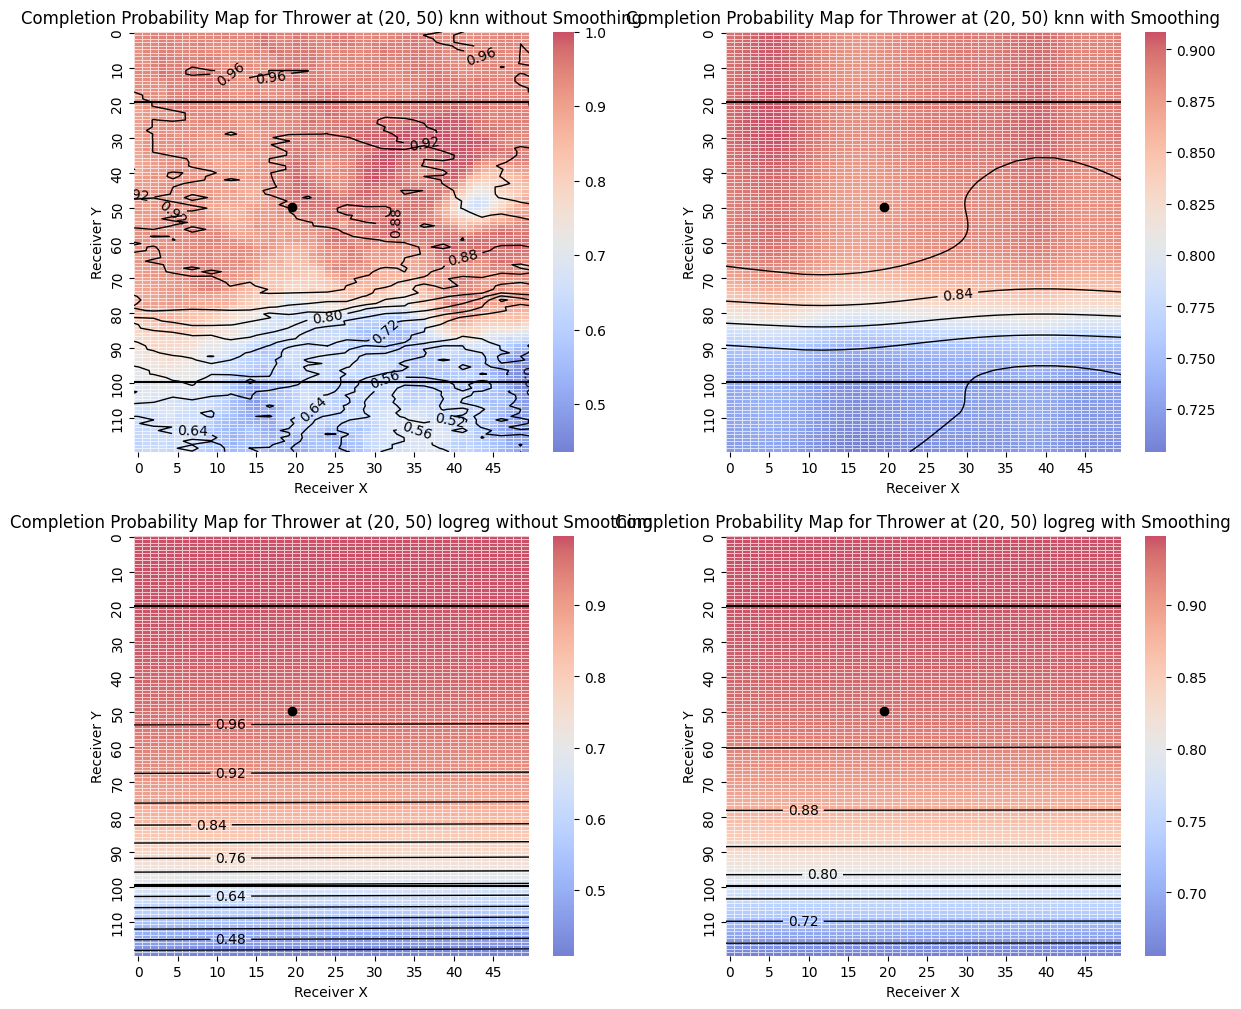

In [50]:
features=['thrower_x', 'thrower_y', 'receiver_x', 'receiver_y']
completion_knn = fit_model(train_df, config['knn'], features=features, target_feature='completion')
output = completion_knn.predict_proba(train_df[features])[:,1]
completion_logreg = fit_model(train_df, config['logreg'], features=features, target_feature='completion')
output = completion_logreg.predict_proba(train_df[features])[:,1]
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
thrower_x=20
thrower_y=50
completion_grid_knn_raw = create_completion_map(completion_knn, thrower_x, thrower_y, ax[0, 0], standard_scaler, smooth=False, contour_every=4, frac=0.2, show=True, title_addition='knn without Smoothing')
completion_grid_knn_smooth = create_completion_map(completion_knn, thrower_x, thrower_y, ax[0, 1], standard_scaler, smooth=True, contour_every=4, frac=0.2, show=True, title_addition='knn with Smoothing')
completion_grid_logreg_raw = create_completion_map(completion_logreg, thrower_x, thrower_y, ax[1, 0], standard_scaler, smooth=False, contour_every=4, frac=0.2, show=True, title_addition='logreg without Smoothing')
completion_grid_logreg_smooth = create_completion_map(completion_logreg, thrower_x, thrower_y, ax[1, 1], standard_scaler, smooth=True, contour_every=4, frac=0.2, show=True, title_addition='logreg with Smoothing')
plt.show()

In [51]:
spacial_map_logreg_smooth_extended = np.vstack((spacial_map_logreg_smooth, np.ones((20, spacial_map_logreg_smooth.shape[1]))))
spacial_map_logreg_raw_extended = np.vstack((spacial_map_logreg_raw, np.ones((20, spacial_map_logreg_raw.shape[1]))))
spacial_map_knn_raw_extended = np.vstack((spacial_map_knn_raw, np.ones((20, spacial_map_knn_raw.shape[1]))))
spacial_map_knn_smooth_extended = np.vstack((spacial_map_knn_smooth, np.ones((20, spacial_map_knn_smooth.shape[1]))))
knn_smooth_score_prob = completion_grid_knn_smooth * spacial_map_knn_smooth_extended
knn_raw_score_prob = completion_grid_knn_raw * spacial_map_knn_raw_extended
logreg_smooth_score_prob = completion_grid_logreg_smooth * spacial_map_logreg_smooth_extended
logreg_raw_score_prob = completion_grid_logreg_raw * spacial_map_logreg_raw_extended

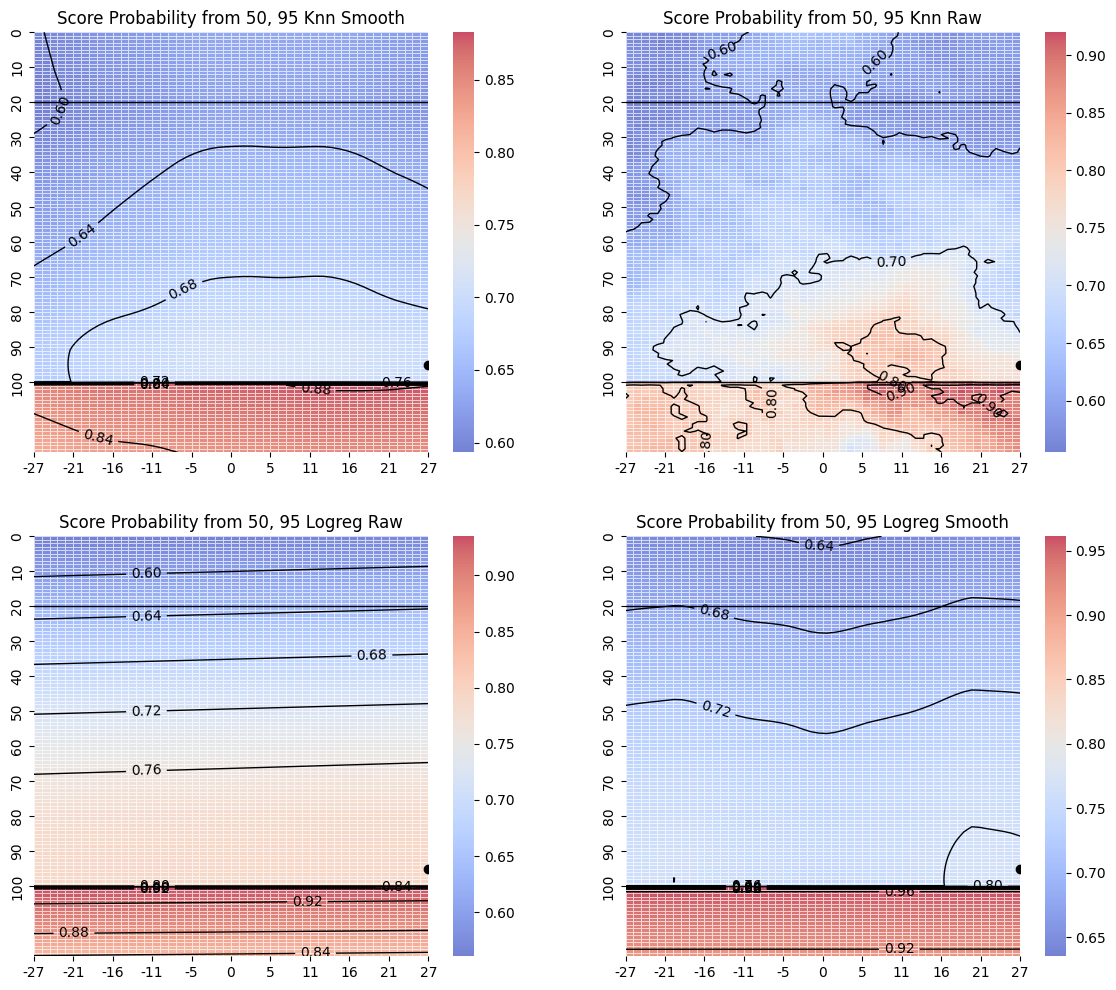

In [52]:
thrower_x=50
thrower_y=95
completion_grid_knn_raw = create_completion_map(completion_knn, thrower_x, thrower_y, ax[0, 0], standard_scaler, smooth=False, contour_every=4, frac=0.2, show=False, title_addition='knn without Smoothing')
completion_grid_knn_smooth = create_completion_map(completion_knn, thrower_x, thrower_y, ax[0, 1], standard_scaler, smooth=True, contour_every=4, frac=0.2, show=False, title_addition='knn with Smoothing')
completion_grid_logreg_raw = create_completion_map(completion_logreg, thrower_x, thrower_y, ax[1, 0], standard_scaler, smooth=False, contour_every=4, frac=0.2, show=False, title_addition='logreg without Smoothing')
completion_grid_logreg_smooth = create_completion_map(completion_logreg, thrower_x, thrower_y, ax[1, 1], standard_scaler, smooth=True, contour_every=4, frac=0.2, show=False, title_addition='logreg with Smoothing')
knn_smooth_score_prob = completion_grid_knn_smooth * spacial_map_knn_smooth_extended
knn_raw_score_prob = completion_grid_knn_raw * spacial_map_knn_raw_extended
logreg_smooth_score_prob = completion_grid_logreg_smooth * spacial_map_logreg_smooth_extended
logreg_raw_score_prob = completion_grid_logreg_raw * spacial_map_logreg_raw_extended
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
knn_smooth_output = plot_score_prob(ax[0,0], train_df, knn_smooth_score_prob, thrower_x, thrower_y, contour_every=4, title=f'Score Probability from {thrower_x}, {thrower_y} Knn Smooth')
knn_raw_output = plot_score_prob(ax[0,1], train_df, knn_raw_score_prob, thrower_x, thrower_y, contour_every=10, title=f'Score Probability from {thrower_x}, {thrower_y} Knn Raw')
logreg_raw_output = plot_score_prob(ax[1,0], train_df, logreg_raw_score_prob, thrower_x, thrower_y, contour_every=4, title=f'Score Probability from {thrower_x}, {thrower_y} Logreg Raw')
logreg_smooth_output = plot_score_prob(ax[1,1], train_df, logreg_smooth_score_prob, thrower_x, thrower_y, contour_every=4, title=f'Score Probability from {thrower_x}, {thrower_y} Logreg Smooth')

In [53]:
test_df_random['spacial_logreg_predictions'] = spacial_logreg.predict_proba(test_df_random[['thrower_x_standard_scaled', 'thrower_y_standard_scaled']])[:,1]

/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [54]:
train_df['opposing_team_thrower_x'] = train_df.thrower_x_standard_scaled * -1
new_thrower_y = train_df.thrower_y_standard_scaled * -1
new_thrower_y[new_thrower_y > train_df.thrower_y_standard_scaled.max()] = train_df.thrower_y_standard_scaled.max()
train_df['opposing_team_thrower_y'] = new_thrower_y
train_df['opposing_team_scoring_probability'] = spacial_logreg.predict_proba(train_df[['opposing_team_thrower_x', 'opposing_team_thrower_y']])[:,1]
train_df['receiver_scoring_probability'] = spacial_logreg.predict_proba(train_df[['receiver_x_standard_scaled', 'receiver_y_standard_scaled']])[:,1]
train_df['receiver_scoring_probability'][train_df.receiver_y > 100] = 1
train_df['spacial_logreg_predictions'] = spacial_logreg.predict_proba(train_df[['thrower_x_standard_scaled', 'thrower_y_standard_scaled']])[:,1]
train_df['play_ec'] = np.where(train_df['completion'] == 1, train_df['receiver_scoring_probability'] - train_df['spacial_logreg_predictions'], 1 - train_df['opposing_team_scoring_probability']- train_df['spacial_logreg_predictions'])
thrower_df = train_df.groupby('thrower')['play_ec'].sum().sort_values()
thrower_df.name = 'throw_ec'
receiver_df = train_df.groupby('receiver')['play_ec'].sum().sort_values()
receiver_df.name = 'catch_ec'

filepath='./data/processed/all_blocks_0926.csv'
block_df = pd.read_csv(filepath)
block_df = block_df.dropna()
X_block = standard_scaler.transform(block_df[['block_x', 'block_y']])
block_df[['block_x_scaled', 'block_y_scaled']] = standard_scaler.transform(block_df[['block_x', 'block_y']])
block_df['spacial_logreg_predictions'] = spacial_logreg.predict_proba(X_block)[:,1]

block_df['opposing_team_block_x'] = block_df.block_x_scaled * -1
new_thrower_y = block_df.block_y_scaled * -1
new_thrower_y[new_thrower_y > block_df.block_y_scaled.max()] = block_df.block_y_scaled.max()
block_df['opposing_team_block_y'] = new_thrower_y
X_block_opposing = block_df[['opposing_team_block_x', 'opposing_team_block_y']]
block_df['spacial_logreg_opposing_predictions'] = 1 - spacial_logreg.predict_proba(X_block_opposing)[:,1]
block_df['block_ec'] = block_df['spacial_logreg_predictions'] - block_df['spacial_logreg_opposing_predictions']
block_ec_df = pd.DataFrame(block_df.groupby('defender')['block_ec'].sum())

/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_76726/2441518045.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexe

In [55]:
train_df['current_line'] = train_df['current_line'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_exploded = train_df.explode('current_line')


results = []
def get_unique_count(player):
    unique_combos = df_exploded[df_exploded['current_line'] == player].drop_duplicates(
        subset=['gameID', 'quarter_point', 'home_team_score', 'away_team_score', 'possession_num']
    )
    return len(unique_combos)
unique_players = df_exploded['thrower'].unique()
for player in tqdm(unique_players):
    count = get_unique_count(player)
    results.append({'thrower': player, 'unique_count': count})
final_df = pd.DataFrame(results)
player_ec_final = pd.merge(thrower_df, final_df, how='left', left_on='thrower', right_on='thrower')
player_ec_final['throw_ec_per_possession'] = player_ec_final.throw_ec / player_ec_final.unique_count

player_ec_final = pd.merge(player_ec_final, block_ec_df, how='left', left_on='thrower', right_on='defender')
player_ec_final['block_ec_per_possession'] = player_ec_final.block_ec / player_ec_final.unique_count

player_ec_final = pd.merge(player_ec_final, receiver_df, how='left', left_on='thrower', right_on='receiver')
player_ec_final['catch_ec_per_possession'] = player_ec_final.catch_ec / player_ec_final.unique_count
player_ec_final = player_ec_final.fillna(0)
player_ec_final['total_ec'] = player_ec_final.catch_ec + player_ec_final.throw_ec + player_ec_final.block_ec
player_ec_final['total_ec_per_possession'] = (player_ec_final.catch_ec + player_ec_final.throw_ec) / player_ec_final.unique_count
thrower_counts = pd.DataFrame(train_df.groupby('thrower').thrower.count())
thrower_counts.columns = ['total_throws']
player_ec_final = pd.merge(player_ec_final, thrower_counts, how='left', left_on='thrower', right_index=True)

100%|██████████| 1391/1391 [01:59<00:00, 11.61it/s]


In [56]:
player_ec_final[player_ec_final.total_throws > 100].sort_values('block_ec_per_possession')

,thrower,throw_ec,unique_count,throw_ec_per_possession,block_ec,block_ec_per_possession,catch_ec,catch_ec_per_possession,total_ec,total_ec_per_possession,total_throws
163,akelly,-1.932944,268,-0.007212,0.000000,0.000000,1.741539,0.006498,-0.191405,-0.000714,374
1175,dsuvorov,0.633548,232,0.002731,0.000000,0.000000,5.189343,0.022368,5.822891,0.025099,181
1162,acarroll,0.563990,121,0.004661,0.000000,0.000000,3.805398,0.031450,4.369388,0.036111,114
1155,schang,0.539332,92,0.005862,0.000000,0.000000,1.505475,0.016364,2.044806,0.022226,119
139,mburton,-2.201934,82,-0.026853,0.000000,0.000000,1.225171,0.014941,-0.976763,-0.011912,134
...,...,...,...,...,...,...,...,...,...,...,...
16,cbrown1,-6.403943,83,-0.077156,4.441072,0.053507,2.598982,0.031313,0.636111,-0.045843,125
1249,ncoolman,1.163753,144,0.008082,8.030030,0.055764,3.484265,0.024196,12.678047,0.032278,120
116,rdrost,-2.546480,229,-0.011120,13.771303,0.060137,4.679524,0.020435,15.904346,0.009315,103
1130,jtom,0.420108,128,0.003282,8.515500,0.066527,3.209479,0.025074,12.145087,0.028356,111


In [57]:
player_ec_final[player_ec_final.total_throws > 100].sort_values('catch_ec_per_possession')[['thrower', 'throw_ec', 'catch_ec', 'total_ec', 'total_ec_per_possession', 'total_throws']]

,thrower,throw_ec,catch_ec,total_ec,total_ec_per_possession,total_throws
369,ddremann,-0.950672,-0.528739,2.548300,-0.010799,167
12,mbennett1,-7.033229,-1.013548,-2.691757,-0.029155,416
373,ecarter,-0.931401,-0.423367,3.083824,-0.010926,130
167,tchrzanow,-1.911865,-0.423083,-2.334948,-0.018242,233
1209,mkissmann,0.798678,-0.524079,0.729405,0.001340,202
...,...,...,...,...,...,...
219,mgibson,-1.633415,10.524135,11.577934,0.038322,190
406,blewis,-0.849083,18.215652,29.889540,0.044078,190
1280,jwhite2,1.537304,7.103753,8.641058,0.063537,208
751,jbabbitt,-0.100796,29.553269,41.041978,0.054141,377


In [58]:
joblib.dump(player_ec_final, './data/processed/player_ec.jblb')

['./data/processed/player_ec.jblb']

Text(33.22222222222222, 0.5, '')

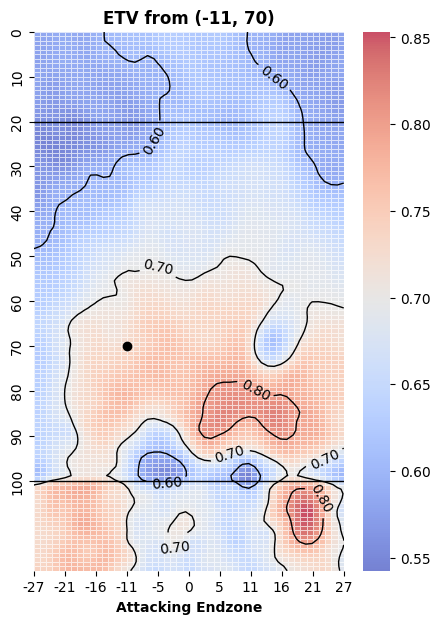

In [72]:
fig, ax = plt.subplots(figsize=(5, 7))
thrower_x=15
thrower_y=70
completion_grid_knn_raw = create_completion_map(completion_knn, thrower_x, thrower_y, ax, standard_scaler, smooth=False, contour_every=4, frac=0.2, show=False, title_addition='knn without Smoothing')
knn_raw_score_prob = completion_grid_knn_raw * spacial_map_knn_raw_extended
# fig, ax = plt.subplots(figsize=(16, 6))
knn_raw_output = plot_score_prob(ax, train_df, knn_raw_score_prob, thrower_x, thrower_y, contour_every=10, title=f'ETV from (-11, 70)', smooth=True)
plt.title(plt.gca().get_title(), fontweight='bold')  # Make the title bold
plt.xlabel(plt.gca().get_xlabel(), fontweight='bold')  # Make the x-axis label bold
plt.ylabel(plt.gca().get_ylabel(), fontweight='bold')  # Make the y-axis label bold

